# VIMA demo

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import os, requests, tarfile, pickle
import vima
import torch
torch.set_default_device('mps') # uncomment if running on a MacBook
vima.set_seed(0) # for reproducibility
os.makedirs(f'./RA/_results', exist_ok=True) # create directory for results

In this demo, we will illustrate how to preprocess and then analyze a case-control spatial dataset using VIMA. The dataset we use for demonstration is an immunohistochemistry dataset of synovial biopsies from rheumatoid arthritis patients, but VIMA can be similarly applied to any spatial modality.

## Input

We assume in this demo that:
1) Each sample has already been rasterized into a set of pixels with a uniform size and stored as an xarray dataarray object in `.nc` format. The process for doing this is technology dependent, but the `vima` function `vima.ingest.hiresarray_to_downsampledxarray` is useful for downsampling a very high-resolution data array, and the `xarray` function [`DataArray.to_netcdf(filename, encoding={sample.name: vi.compression}, engine="netcdf4")`](https://docs.xarray.dev/en/v0.10.4/generated/xarray.DataArray.to_netcdf.html) is useful for saving xarray dataarrays as `.nc` files.
2) All the dataarray objects are in the same directory.
3) The filename of each object includes a sample ID.

The input files in this format that are necessary for the demo are posted as a [zenodo record](https://zenodo.org/records/14838525). Let's download them now.

In [ ]:
url = "https://zenodo.org/records/17694679/files/RA.tar.gz?download=1"
target_dir = "./"
tar_file = "RA.tar.gz"

# Download the file
if not os.path.exists(tar_file):
    print(f"Downloading {tar_file}...")
    response = requests.get(url, stream=True)
    with open(tar_file, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print(f"Downloaded {tar_file}.")
else:
    print(f"{tar_file} already exists. Skipping download.")

# Decompress the file
print(f"Decompressing {tar_file}...")
with tarfile.open(tar_file, "r:gz") as tar:
    tar.extractall(target_dir)
print(f"Decompressed into {target_dir}.")

RA.tar.gz already exists. Skipping download.
Decompressing RA.tar.gz...
Decompressed into ./.


## Overview of this notebook

The `vima` workflow has three major parts: 1) preprocessing, whereby the marker levels (or expression counts) in the pixels are normalized, non-spatial batch effects and sample-specific artifacts are removed, and the markers are converted into meta-markers, and 2) model training, and 3) case-control analysis

## 1. Preprocessing

Here we specify what is needed for our preprocessing pipeline to work, including: the number of meta-markers to produce, the name of the folder in which we will store the output, and information about the markers that are profiled in the raw data

In [2]:
# data location
rootdir = './RA/'
outdir = './RA/'

# parameters
nmetamarkers = 5
repname = f'pca_k={nmetamarkers}_harmony'

# define markers and marker subsets
markers = ['DAPI', 'CLIC5', 'CD34', 'HLADR', 'CD3', 'CD90', 'CD68', 'AF']
real_markers = markers[:-1]
neg_ctrls = markers[-1:] # these are auto-fluorescence markers that we will use to normalize the true markers

We next define several functions that are specific to this dataset and define 1) what counts as tissue vs background, and 2) how to normalize the pixels in a given sample. Most of this is not necessary in spatial transcriptomics (ST) datasets, as `vima`'s default functions are sufficient. (E.g., in ST data we can just use the functions `vi.foreground_mask_st`, `vi.get_sumstats_st`, and `vi.normalize_st` directly.)

In [3]:
# Dataset-specific functions -- not necessary for a standard spatial transcriptomics dataset

# define how tissue is differentiated from background
def get_foreground(s):
    if s.name == '300-0529_Scan1':
        s = s.where(s.x < 12500, 0) # we manually remove part of this specific sample because of an
                                    # area of artifact so large that it skews our QC
    return vima.pp.foreground_mask_ihc(s, real_markers, neg_ctrls, 0.1, 12, blur_width=5)

# define how pixel-level counts are normalized to account for autofluorescence
def norm_by_AF(X):
    return real_markers, (X[:,:-1]) / (1+X[:,-1])[:,None]

# define functions needed for normalization using VIMA skeletons
get_sumstats = lambda x: vima.pp.get_sumstats_nonst(norm_by_AF, x)
normalize = lambda *args, **kwargs: vima.pp.normalize_nonst(norm_by_AF, *args, **kwargs)

We now process each sample to define tissue regions, normalize the marker levels, and conduct pca on the pixels to reduce the number of markers. The resulting PCA'd markers are not yet integrated with `harmony`. For now this is done manually using the `R` implementation of `harmony`, which we will do below.

"300-0502_Scan1": 132699 (5%) pixels non-empty| "300-0307_Scan1": 73001 (2%) pixels non-empty| "300-0309_Scan3": 60530 (1%) pixels non-empty| "300-1933_Scan2": 127740 (2%) pixels non-empty| "300-0251_Scan1": 9355 (7%) pixels non-empty| "300-0143_Scan1": 43693 (7%) pixels non-empty| "300-0302_Scan2": 168439 (4%) pixels non-empty| "300-0145_Scan1": 54308 (3%) pixels non-empty| "300-0183_Scan1": 75157 (3%) pixels non-empty| "300-0504_Scan1": 65611 (3%) pixels non-empty| "300-2665_Scan1": 94952 (2%) pixels non-empty| "300-1934_Scan3": 73568 (1%) pixels non-empty| "300-0504_Scan2": 62725 (3%) pixels non-empty| "300-0529_Scan1": 15316 (0%) pixels non-empty| "300-0491_Scan1": 148954 (8%) pixels non-empty| "300-2660_Scan1": 103265 (8%) pixels non-empty| "300-0501_Scan1": 118215 (5%) pixels non-empty| "300-1933_Scan1": 63401 (2%) pixels non-empty| "300-0310_Scan2": 110011 (3%) pixels non-empty| "300-0309_Scan1": 9537 (34%) pixels non-empty| "300-1879_Scan1": 254919 (8%) pixels non-empty| "300-0

100%|███████████████████████████████████████████████████████████████| 27/27 [00:07<00:00,  3.39it/s]


computing sumstats
normalizing and writing


100%|███████████████████████████████████████████████████████████████| 27/27 [00:15<00:00,  1.77it/s]


creating metapixels prior to PCA


27it [00:08,  3.27it/s]
/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


merging and standardizing metapixels


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


(3306822, 7)
performing PCA


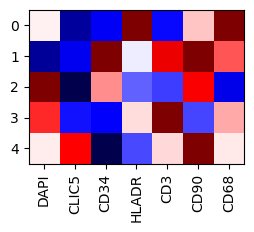

reading in pixels


100%|███████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.45it/s]


applying dimensionality reduction
visualizing


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


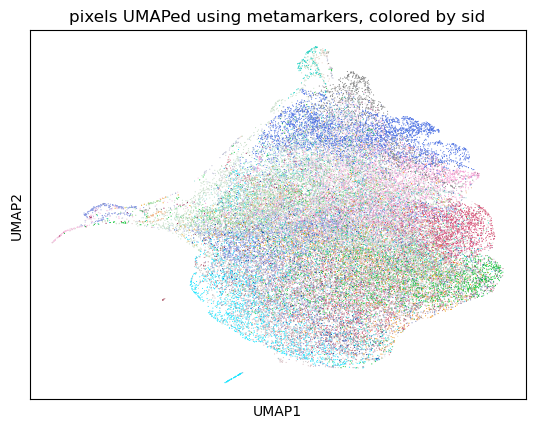

=== running harmony ===


Loading required package: Rcpp
code for methods in class “Rcpp_harmony” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)
code for methods in class “Rcpp_harmony” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Attaching package: ‘arrow’

The following object is masked from ‘package:utils’:

    timestamp

Detected available cores: 12
Requested ncores = 32 but only 12 available. Using ncores = 12.


Input file: /var/folders/w_/x2_v44_93nq_b3svp199t1rw0000gn/T/tmpiz3gu7ly.feather 
Detected available cores: 12 
Using ncores: 12 
Metadata: sid 
Running Harmony...


Transposing data matrix
Initializing state using k-means centroids initialization
Harmony 1/10
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 2/10
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 3/10
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|---

Harmony completed successfully.
Writing output to: /var/folders/w_/x2_v44_93nq_b3svp199t1rw0000gn/T/tmpiz3gu7ly_harmony.feather 
Done.
=== finished running harmony ===


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


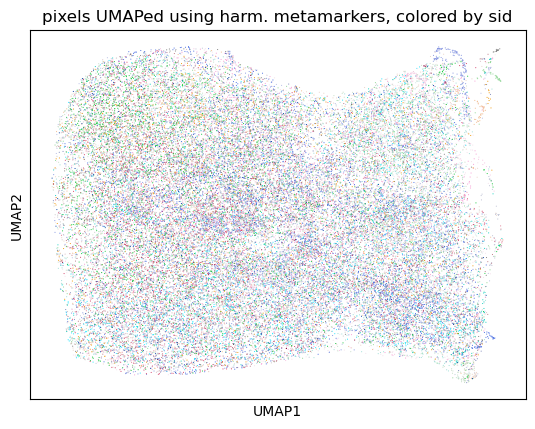

100%|███████████████████████████████████████████████████████████████| 27/27 [00:13<00:00,  2.02it/s]


In [ ]:
# perform qc and convert markers to meta-markers
allpixels_pca = vima.pp.preprocess(outdir, repname, get_foreground, get_sumstats, normalize, nmetamarkers=nmetamarkers)

# harmonize the meta-markers and write the results
harmpixels = vima.pp.harmonize(allpixels_pca, '/path/to/your/Rscript') # you must supply a path to an Rscript executable in an environment in which harmony is installed
vima.pp.write_harmonized(outdir, repname, harmpixels)

Finally, `vima` offers some sanity checks to give us a chance to spot any obvious problems

all PCs of one sample
histogram of each pc
01234

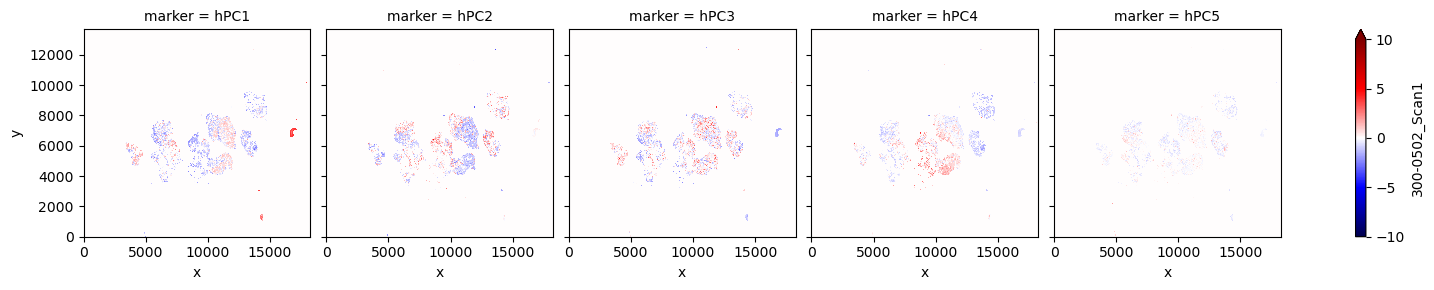

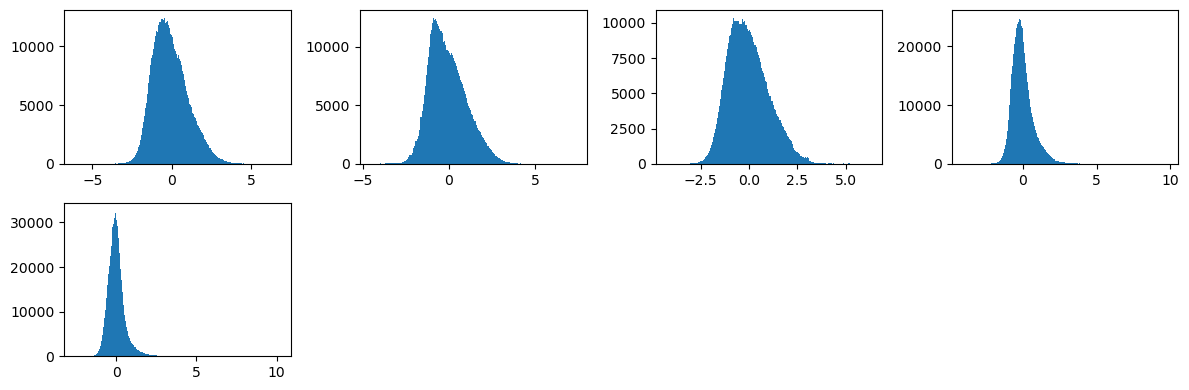

PC1 of several samples


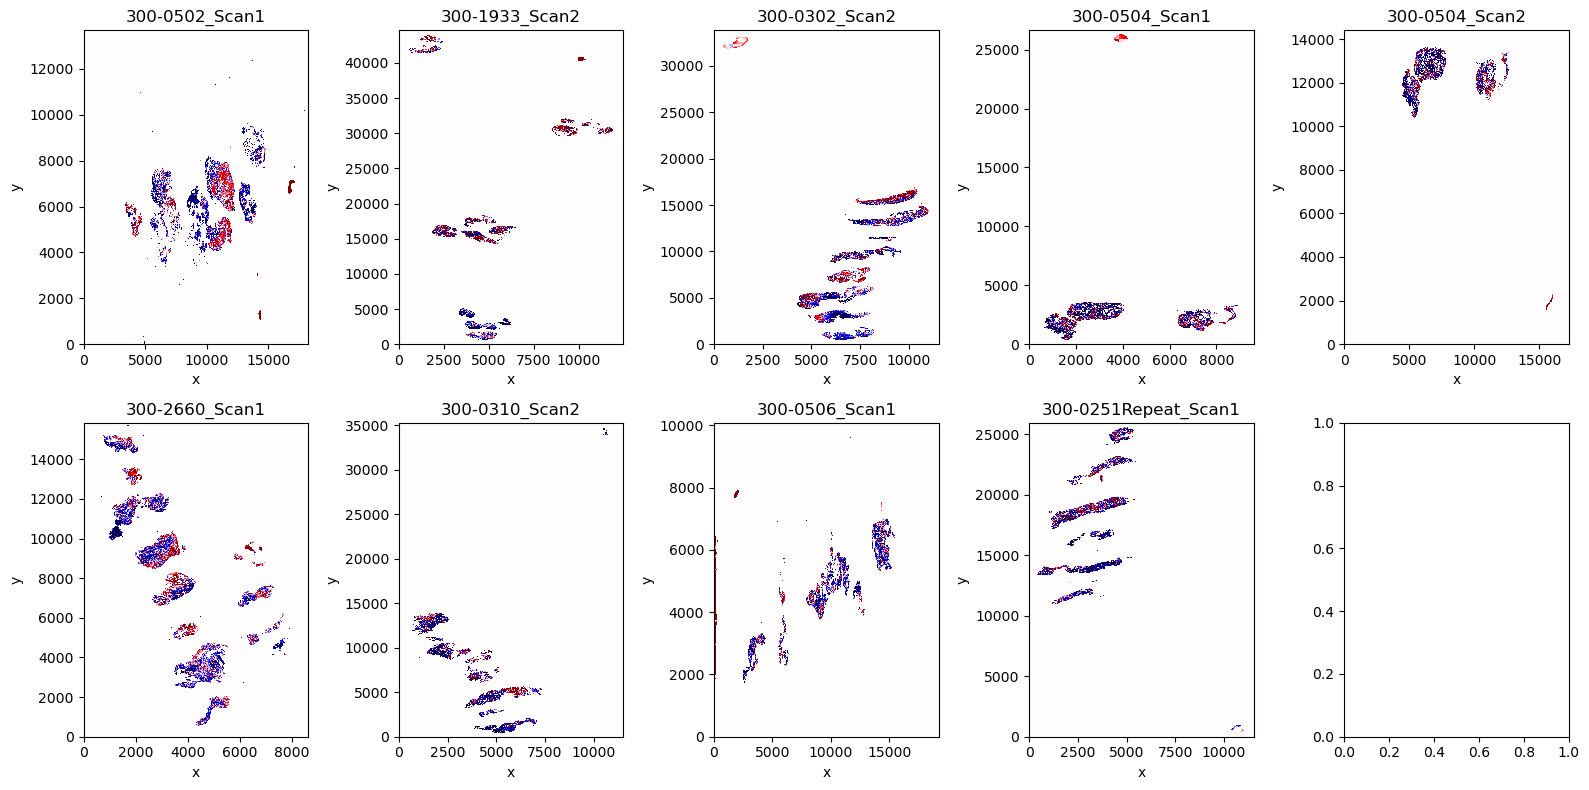

In [6]:
# visual sanity checks
vima.pp.sanity_checks(outdir, repname)

## 2. Model training

We now turn to training the `vima` model on our preprocessed data. This involves reading in the data, generating tissue patches, and training the variational autoencoder.

We first read in all the samples together with their metadata

In [3]:
# read in samples
def fname_parser(fname):
    fname = os.path.splitext(os.path.basename(fname))[0]
    return {
        'donor': fname.split('_')[0].replace('Repeat',''),
        'sid': fname
    }
repname = 'pca_k=5_harmony'
samples = vima.read_samples(f'RA/{repname}/*.nc', fname_parser)

# read in and reformat sample metadata
fullmeta = pd.read_csv('RA/metadata.csv').set_index('subject_id')[['CTAP']]
fullmeta.index = fullmeta.index.str.replace('V0', '') # reformat sample names
fullmeta['fstar'] = (fullmeta.CTAP == 'F') | (fullmeta.CTAP == 'T + F') | (fullmeta.CTAP == 'E + F + M') # define our phenotype

100%|███████████████████████████████████████████████████████████████| 27/27 [00:06<00:00,  4.49it/s]


We now generate two sets of patches: one for training, and a smaller set of "high-quality" patches for the case-control analysis

In [4]:
# choose which patches to train on
P = vima.PatchCollection(samples)
print(len(P), 'patches')

# choose which patches to do case/ctrl analysis on
Pdense = vima.PatchCollection(samples, max_frac_empty=0.2, sid_nums=P.sid_nums)
print(len(Pdense), 'dense patches')

# change samplemeta so that each row is a sample rather than a donor
inourdata = P.meta[['sid','donor']].drop_duplicates()
samplemeta = pd.merge(inourdata, fullmeta, left_on='donor', right_index=True, how='left').set_index('sid', drop=True)

100%|███████████████████████████████████████████████████████████████| 27/27 [00:07<00:00,  3.51it/s]


in pytorch mode
means: [-0.0524431  -0.03230652 -0.00229248 -0.02602123  0.00177635]
stds: [0.79002345 0.7820083  0.7568341  0.52883524 0.3928828 ]
data augmentation is off
39302 patches


100%|███████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.05it/s]


in pytorch mode
means: [-0.01986327  0.01847045  0.16047706  0.01280842  0.03556518]
stds: [1.0031661  1.0235859  0.9741484  0.6844724  0.53859794]
data augmentation is off
10345 dense patches


Now that we have the patches we can train the autoencoder and save an instance of the trained model.

end of epoch 20: avg val loss = 0.5896835923194885
time elapsed this epoch: 90.83 sec
total time elapsed: 2070.41 sec


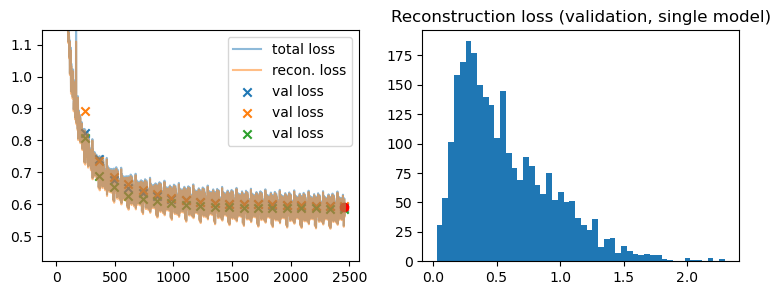

best validation losses so far across full model ensemble: [0.5917829, 0.5929472, 0.5843207]
best epochs so far across full model ensemble: [20, 20, 20]


In [ ]:
models = vima.models.cVAE(P.nmarkers, P.nsamples)

log = vima.train(models, P, n_epochs=10)
log2 = vima.train(models, Pdense, n_epochs=20)
torch.save(models.state_dict(), f'_results/models.pt')

Once the model is trained, we load it from disk and apply it to the set of patches that are meant for case-control analysis to generate their patch fingerprints.

In [7]:
# load model
model = vima.models.cVAE(P.nmarkers, P.nsamples)
model.load_state_dict(torch.load(f'RA/_results/models.pt'))

# apply model and build nearest-neighbor graphs
ds = vima.latentreps(model, Pdense)
pickle.dump(ds, open(f'RA/_results/fingerprints.pkl', 'wb'))

applying models
in pytorch mode
data augmentation is off


100%|███████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.35it/s]


computing nearest-neighbor graphs


100%|███████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.35s/it]


Now we can read in the the patch fingerprints and conduct the case-control analysis. The output is a global P-value for association as well as a set of significant microniches at FDR 10%.

## Case-control analysis

In [8]:
p, D = vima.association(ds, samplemeta.fstar, 'sid', donorids=samplemeta.donor)
print(f'found {(D.obs.mncoef_fdr <= 0.1).sum()} microniches at FDR 10%')

computing MAMs
performing association test
P = 0.00019998000199980003
Gamma p-value = 5.442012006318109e-05
         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


found 5668 microniches at FDR 10%


We can then visualize the output by making a umap

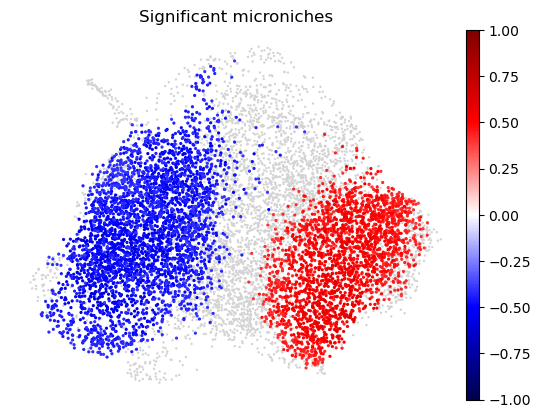

In [9]:
sc.pl.umap(D, ax=plt.gca(), show=False, frameon=False)
sc.pl.umap(D[D.obs.mncoef_fdr <= 0.1], color='mncoef', cmap='seismic', vmin=-1, vmax=1,
           ax=plt.gca(), frameon=False, title='Significant microniches')

Or we can look at the results in more detail

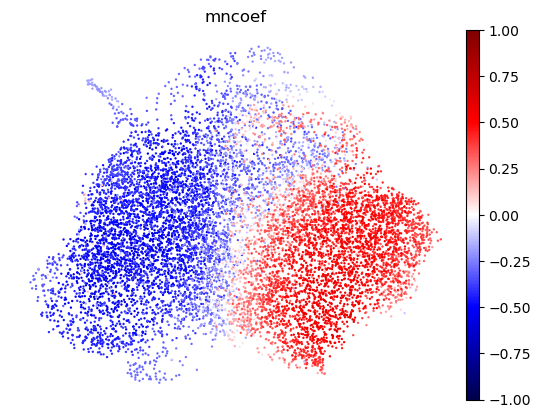

In [10]:
# the correlation for each microniche between its abundance and case/ctrl status, regardless of significance
sc.pl.umap(D, color='mncoef', frameon=False, cmap='seismic', vmin=-1, vmax=1)

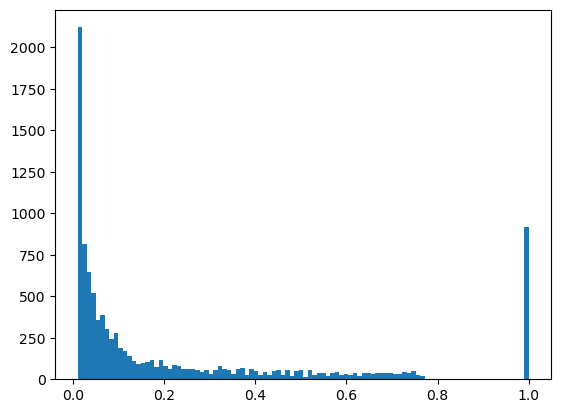

In [11]:
# the FDR at which each microniche is significant
plt.hist(D.obs.mncoef_fdr, bins=100)
plt.show()

`vima` can also supply other information on the results if `association` is called with `return_full=True`. More documentation on these is forthcoming.